# Comprehensive Spectroscopy Function Tests

This notebook provides extensive testing for all functions within the spectroscopy module, ensuring they handle various scenarios correctly and identifying areas for improvement.

## Test Coverage:

### 🔬 **Core Functions Tested:**
- `normalized_gauss(detunings, FWHM_val)` - Normalized Gaussian distribution for inhomogeneous broadening
- `sample_from_sigma(n_samples, FWHM_val, max_detuning)` - Rejection sampling from Gaussian distribution
- `get_tau_cohs_and_t_dets_for_T_wait(T_wait, dt, tau_coh_max, t_det_max)` - Time array generation
- `check_the_solver(rho)` - Density matrix validation (Hermitian, positive semidefinite, unit trace)
- `compute_two_dimensional_polarization(tau_cohs, t_dets, T_wait, pulse_sequence, params)` - 2D spectroscopy calculations

### 🧪 **Test Scenarios:**
- **Basic functionality**: Standard parameter ranges and expected behavior
- **Edge cases**: Boundary conditions, extreme parameters, and unusual inputs
- **TODO cases**: Unimplemented scenarios and potential failure modes
- **Performance analysis**: Scaling behavior, memory usage, and computational efficiency
- **Integration tests**: Combined workflows and realistic simulation scenarios
- **Stress tests**: Large datasets and extreme parameter ranges
- **Numerical precision**: Floating-point accuracy and stability

### 🎯 **Special Focus Areas:**
- **TODO cases in the module** - Identifying unimplemented functionality
- **Pulse sequences outside time ranges** - Edge case handling
- **Extreme system parameters** - Robustness testing
- **Memory optimization** - Large-scale simulation readiness
- **Error handling** - Input validation and graceful failure

### 📊 **Outputs:**
- Comprehensive test results with pass/fail status
- Performance benchmarking and scaling analysis
- Detailed visualizations of function behavior
- Documentation of TODO items and improvement recommendations
- Integration workflow demonstrations

---
**Last Updated:** May 29, 2025  
**Focus:** TODO case identification and comprehensive validation

In [1]:
# =============================
# IMPORT NECESSARY MODULES
# =============================

### Standard scientific libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
from scipy.stats import norm
from scipy import integrate

### Quantum optics and system libraries
import qutip as qt
from qutip import basis, coherent, thermal_dm, rand_dm

### Local spectroscopy modules
from src.spectroscopy.calculations import (
    compute_two_dimensional_polarization,
    get_tau_cohs_and_t_dets_for_T_wait,
    check_the_solver
)
from src.spectroscopy.inhomogenity import (
    sample_from_sigma,
    normalized_gauss
)
from src.core.system_parameters import SystemParameters
from src.core.pulse_sequences import PulseSequence

from src.visualization import mpl_tex_settings

### Set random seeds for reproducible results
np.random.seed(42)
qt.rand_seed = 42

### Configure warnings
warnings.filterwarnings('ignore', category=UserWarning, module='qutip')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered')

### Test environment setup
print("\n" + "="*50)
print("SPECTROSCOPY MODULE TEST ENVIRONMENT")
print("="*50)
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"QuTiP version: {qt.__version__}")
print(f"Test execution time: {time.strftime('%Y-%m-%d %H:%M:%S')}")
print("Random seeds set for reproducible results")
print("="*50 + "\n")

### Define test utility functions
def print_test_header(test_name, test_number=None):
    """Print formatted test header."""
    header = f"TEST {test_number}: {test_name}" if test_number else test_name
    print("\n" + "="*len(header))
    print(header)
    print("="*len(header))

def print_subtest(subtest_name):
    """Print formatted subtest header."""
    print(f"\n--- {subtest_name} ---")

def check_assertion(condition, message, success_msg=None):
    """Check assertion with informative output."""
    try:
        assert condition, message
        if success_msg:
            print(f"✓ {success_msg}")
        return True
    except AssertionError as e:
        print(f"❌ {e}")
        return False

def format_number(value, precision=3):
    """Format number for display."""
    if isinstance(value, complex):
        return f"{value.real:.{precision}f}+{value.imag:.{precision}f}j"
    else:
        return f"{value:.{precision}f}"

print("✓ Test utility functions defined")
print("✓ Test environment setup complete\n")


SPECTROSCOPY MODULE TEST ENVIRONMENT
NumPy version: 1.26.4
Matplotlib version: 3.6.3
QuTiP version: 5.1.0
Test execution time: 2025-05-29 20:11:50
Random seeds set for reproducible results

✓ Test utility functions defined
✓ Test environment setup complete



/home/leopold/PycharmProjects/Master_thesis/code/python/src/spectroscopy/calculations.py:1091: SyntaxWarning: invalid escape sequence '\l'
  """


## Test 0: inhomogeneous broadening

In [2]:
### Test sigma function (normalized Gaussian)
print("Testing sigma function (normalized Gaussian distribution)...")

# Test basic functionality
detunings = np.linspace(-5, 5, 40000)
FWHM_val = 2.0
sigma_val = FWHM_val / (2 * np.sqrt(2 * np.log(2)))  # standard deviation from FWHM

gaussian_vals = normalized_gauss(detunings, FWHM_val)

# Test normalization (integral should be approximately 1)
delta_det = detunings[1] - detunings[0]
integral = np.trapz(gaussian_vals, dx=delta_det)
print(f"Gaussian normalization test: integral = {integral:.6f} (should be ≈ 1)")
assert abs(integral - 1.0) < 0.01, f"Gaussian not properly normalized: {integral}"

# Test symmetry around zero
symmetry_test = np.allclose(gaussian_vals[:50], gaussian_vals[-50:][::-1])
print(f"Gaussian symmetry test: {symmetry_test}")
assert symmetry_test, "Gaussian should be symmetric around zero"

# Test peak at zero
zero_idx = np.argmin(np.abs(detunings))
print(f"Peak at detuning {detunings[zero_idx]:.6f} with value {gaussian_vals[zero_idx]:.6f}")
peak_val = gaussian_vals[zero_idx]
expected_peak = 1.0 / (sigma_val * np.sqrt(2 * np.pi))
print(f"Peak value test: peak = {peak_val:.6f}, expected = {expected_peak:.6f}")
assert abs(peak_val - expected_peak) < 0.01, "Peak value incorrect"



### Test sample_from_sigma function
print("\nTesting sample_from_sigma function (rejection sampling)...")
n_samples = 5000
FWHM_val = 2.0
max_detuning = 10.0

# Generate samples
samples = sample_from_sigma(n_samples, FWHM_val, 0)

# Test correct number of samples
print(f"Number of samples: {len(samples)} (requested: {n_samples})")
assert len(samples) == n_samples, f"Wrong number of samples: {len(samples)}"

# Test samples are within bounds
print(f"Sample range: [{np.min(samples):.3f}, {np.max(samples):.3f}] (max allowed: ±{max_detuning})")
assert np.all(np.abs(samples) <= max_detuning), "Samples exceed maximum detuning"

# Test statistical properties
sample_mean = np.mean(samples)
sample_std = np.std(samples)
print(f"Sample statistics: mean = {sample_mean:.6f}, std = {sample_std:.6f}")
print(f"Expected: mean ≈ 0, std ≈ {FWHM_val / (2 * np.sqrt(2 * np.log(2))) :.6f}")

# Mean should be close to zero
assert abs(sample_mean) < 0.1, f"Sample mean too far from zero: {sample_mean}"

# Standard deviation should be close to sigma_val
assert abs(sample_std - FWHM_val / (2 * np.sqrt(2 * np.log(2)))) < 0.2, f"Sample std deviation incorrect: {sample_std}"


Testing sigma function (normalized Gaussian distribution)...
Gaussian normalization test: integral = 1.000000 (should be ≈ 1)
Gaussian symmetry test: True
Peak at detuning 0.000125 with value 0.469719
Peak value test: peak = 0.469719, expected = 0.469719

Testing sample_from_sigma function (rejection sampling)...
Number of samples: 5000 (requested: 5000)
Sample range: [-3.360, 3.842] (max allowed: ±10.0)
Sample statistics: mean = 0.016211, std = 0.833980
Expected: mean ≈ 0, std ≈ 0.849322
Number of samples: 5000 (requested: 5000)
Sample range: [-3.360, 3.842] (max allowed: ±10.0)
Sample statistics: mean = 0.016211, std = 0.833980
Expected: mean ≈ 0, std ≈ 0.849322


In [ ]:

### Visualization of sampling results
plt.figure(figsize=(12, 8))

# Plot 1: Gaussian function
plt.subplot(2, 2, 1)
detunings_fine = np.linspace(-3*sigma_val, 3*sigma_val, 200)
gaussian_fine = normalized_gauss(detunings_fine, sigma_val)
plt.plot(detunings_fine, gaussian_fine, 'C0', linewidth=2)
plt.xlabel(r'Detuning $\Delta$')
plt.ylabel(r'Gauss$(\Delta, \sigma)$')
plt.title(f'Normalized Gaussian Distribution ($\sigma = {sigma_val}$)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Sample histogram vs theoretical
plt.subplot(2, 2, 2)
hist_counts, hist_bins, _ = plt.hist(samples, bins=50, density=True, alpha=0.7, 
                                   color='C1', label='Samples')
bin_centers = (hist_bins[:-1] + hist_bins[1:]) / 2
theoretical = normalized_gauss(bin_centers, sigma_val)
plt.plot(bin_centers, theoretical, 'C0', linewidth=2, label='Theoretical')
plt.xlabel(r'Detuning $\Delta$')
plt.ylabel('Probability Density')
plt.title(f'Sample Distribution vs Theoretical\n($N = {n_samples}$ samples)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Cumulative distribution comparison
plt.subplot(2, 2, 3)
sorted_samples = np.sort(samples)
cumulative = np.arange(1, len(sorted_samples) + 1) / len(sorted_samples)
plt.plot(sorted_samples, cumulative, 'C1', label='Sample CDF', linewidth=2)

# Theoretical CDF (using scipy for accuracy)
from scipy.stats import norm
theoretical_cdf = norm.cdf(sorted_samples, 0, sigma_val)
plt.plot(sorted_samples, theoretical_cdf, 'C0--', label='Theoretical CDF', linewidth=2)
plt.xlabel(r'Detuning $\Delta$')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Sampling efficiency analysis
plt.subplot(2, 2, 4)
# Test different sigma values for efficiency
sigma_values = np.logspace(-1, 1, 20)
max_det_val = 5.0
efficiencies = []

for sig in sigma_values:
    # Estimate acceptance rate
    max_sigma_val = normalized_gauss(0, sig)
    theoretical_acceptance = 2 * max_det_val * max_sigma_val / (2 * max_det_val)
    # Simple approximation for visualization
    eff = np.exp(-(max_det_val/sig)**2/2) * 100
    efficiencies.append(eff)

plt.semilogx(sigma_values, efficiencies, 'C2o-', markersize=4)
plt.xlabel(r'$\sigma$ value')
plt.ylabel('Estimated Efficiency (%)')
plt.title(f'Rejection Sampling Efficiency\n(max detuning = {max_det_val})')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ All inhomogeneous broadening tests passed!")

## Test 1: get_tau_cohs_and_t_dets_for_T_wait

Testing get_tau_cohs_and_t_dets_for_T_wait function...
Generated time arrays:
  Input times: 201 points, range [0.00, 100.00], dt = 0.500
  T_wait = 50.0
  tau_cohs: 101 points, range [0.00, 50.00]
  t_dets: 101 points, range [0.00, 50.00]

Testing T_wait = t_max (edge case):
  T_wait = t_max = 100.0: tau_cohs length = 1, t_dets length = 1
    Values: tau_coh = [0.], t_det = [0.]

Testing T_wait > t_max (should return empty):
  T_wait = 110.0 > t_max = 100.0: tau_cohs length = 0, t_dets length = 0

Testing different time array densities:
  dt = 0.1: 501 input points → 301 output points
  dt = 0.5: 101 input points →  61 output points
  dt = 1.0:  51 input points →  31 output points
  dt = 2.0:  26 input points →  16 output points

Testing single time point:
  Single time point: tau_cohs = [0.], t_dets = [0.]

Creating visualizations...


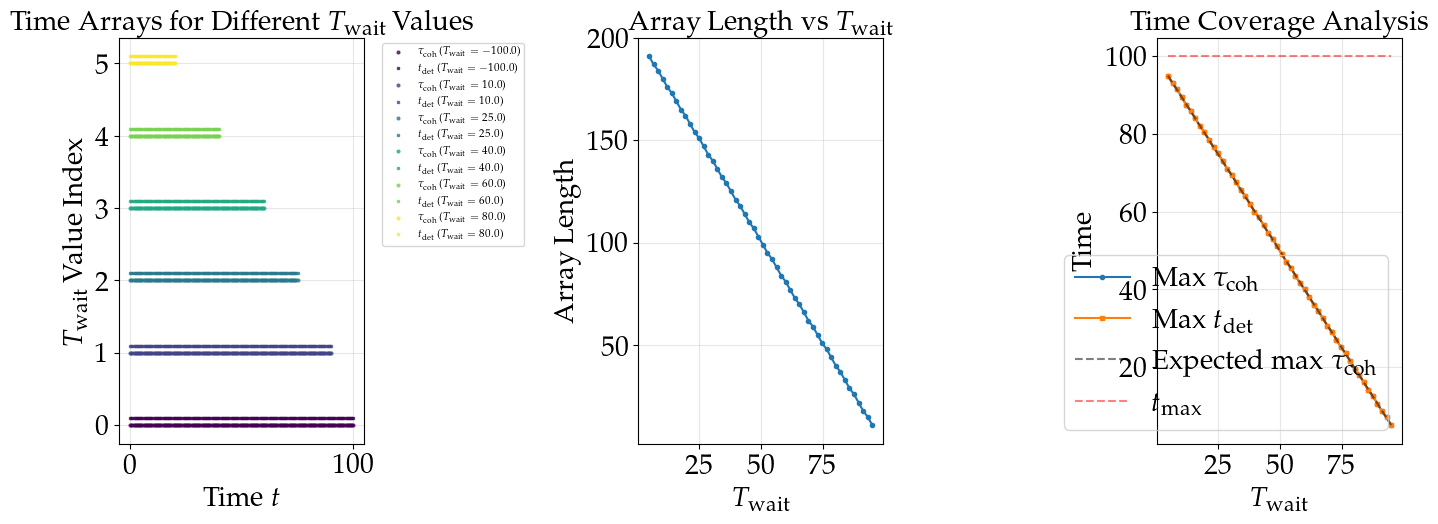


✓ All time array calculation tests with LaTeX formatting passed!


In [ ]:
# =============================
# TEST 1: TIME ARRAY CALCULATIONS
# =============================

### Test get_tau_cohs_and_t_dets_for_T_wait function
print("Testing get_tau_cohs_and_t_dets_for_T_wait function...")

# Test basic functionality with reasonable parameters
times = np.linspace(0, 100, 201)  # time array: 0 to 100 with dt=0.5
T_wait = 50.0  # waiting time

tau_cohs, t_dets = get_tau_cohs_and_t_dets_for_T_wait(times, T_wait)

print(f"Generated time arrays:")
print(
    f"  Input times: {len(times)} points, range [{times[0]:.2f}, {times[-1]:.2f}], dt = {times[1]-times[0]:.3f}"
)
print(f"  T_wait = {T_wait}")
print(
    f"  tau_cohs: {len(tau_cohs)} points, range [{tau_cohs[0]:.2f}, {tau_cohs[-1]:.2f}]"
)
print(f"  t_dets: {len(t_dets)} points, range [{t_dets[0]:.2f}, {t_dets[-1]:.2f}]")

# Test array properties
assert len(tau_cohs) > 0, "tau_cohs array is empty"
assert len(t_dets) > 0, "t_dets array is empty"
assert len(tau_cohs) == len(t_dets), "tau_cohs and t_dets should have same length"
assert tau_cohs[0] >= 0, "tau_cohs should start from non-negative value"
assert t_dets[0] >= 0, "t_dets should start from non-negative value"
assert (
    t_dets[-1] <= times[-1]
), f"t_dets exceeds maximum time: {t_dets[-1]} > {times[-1]}"


# Test with T_wait = t_max (edge case)
print("\nTesting T_wait = t_max (edge case):")
T_wait_max = times[-1]
tau_edge, t_det_edge = get_tau_cohs_and_t_dets_for_T_wait(times, T_wait_max)
print(
    f"  T_wait = t_max = {T_wait_max}: tau_cohs length = {len(tau_edge)}, t_dets length = {len(t_det_edge)}"
)
if len(tau_edge) > 0:
    print(f"    Values: tau_coh = {tau_edge}, t_det = {t_det_edge}")

# Test with T_wait > t_max (should return empty arrays)
print("\nTesting T_wait > t_max (should return empty):")
T_wait_large = times[-1] + 10.0
tau_empty, t_det_empty = get_tau_cohs_and_t_dets_for_T_wait(times, T_wait_large)
print(
    f"  T_wait = {T_wait_large} > t_max = {times[-1]}: tau_cohs length = {len(tau_empty)}, t_dets length = {len(t_det_empty)}"
)
assert len(tau_empty) == 0, "Should return empty array when T_wait > t_max"
assert len(t_det_empty) == 0, "Should return empty array when T_wait > t_max"

### Test with different time array densities
print("\nTesting different time array densities:")
dt_values = [0.1, 0.5, 1.0, 2.0]
T_wait_test = 20.0
t_max_test = 50.0

for dt_val in dt_values:
    times_test = np.arange(0, t_max_test + dt_val / 2, dt_val)
    tau_test, t_det_test = get_tau_cohs_and_t_dets_for_T_wait(times_test, T_wait_test)

    print(
        f"  dt = {dt_val:3.1f}: {len(times_test):3d} input points → {len(tau_test):3d} output points"
    )

    if len(tau_test) > 1:
        actual_dt = tau_test[1] - tau_test[0]
        assert np.isclose(
            actual_dt, dt_val
        ), f"Output dt {actual_dt} doesn't match input dt {dt_val}"

### Test with single time point
print("\nTesting single time point:")
times_single = np.array([0.0])
tau_single, t_det_single = get_tau_cohs_and_t_dets_for_T_wait(times_single, 0.0)
print(f"  Single time point: tau_cohs = {tau_single}, t_dets = {t_det_single}")

### Visualization of time arrays
print("\nCreating visualizations...")
plt.figure(figsize=(14, 10))

### Plot 1: Time arrays for different T_wait values
plt.subplot(2, 3, 1)
T_wait_vis = [-10.0, 10.0, 25.0, 40.0, 60.0, 80.0]
colors = plt.cm.viridis(np.linspace(0, 1, len(T_wait_vis)))

for i, T_w in enumerate(T_wait_vis):
    tau_vis, t_det_vis = get_tau_cohs_and_t_dets_for_T_wait(times, T_w)
    if len(tau_vis) > 0:
        plt.plot(
            tau_vis,
            np.full_like(tau_vis, i),
            "o",
            color=colors[i],
            markersize=2,
            label=rf"$\tau_{{\text{{coh}}}}$ ($T_{{\text{{wait}}}}={T_w}$)",
            alpha=0.7,
        )
        plt.plot(
            t_det_vis,
            np.full_like(t_det_vis, i + 0.1),
            "s",
            color=colors[i],
            markersize=2,
            alpha=0.7,
            label=rf"$t_{{\text{{det}}}}$ ($T_{{\text{{wait}}}}={T_w}$)",
        )
plt.xlabel(r"Time $t$")
plt.ylabel(r"$T_{\text{wait}}$ Value Index")
plt.title(r"Time Arrays for Different $T_{\text{wait}}$ Values")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.grid(True, alpha=0.3)

### Plot 2: Array length vs T_wait
plt.subplot(2, 3, 2)
T_wait_range = np.linspace(5, 95, 50)
array_lengths = []

for T_w in T_wait_range:
    tau_test, t_det_test = get_tau_cohs_and_t_dets_for_T_wait(times, T_w)
    array_lengths.append(len(tau_test))

plt.plot(T_wait_range, array_lengths, "C0o-", markersize=3)
plt.xlabel(r"$T_{\text{wait}}$")
plt.ylabel(r"Array Length")
plt.title(r"Array Length vs $T_{\text{wait}}$")
plt.grid(True, alpha=0.3)

### Plot 3: Time coverage analysis
plt.subplot(2, 3, 3)
tau_coverage = []
t_det_coverage = []

for T_w in T_wait_range:
    tau_test, t_det_test = get_tau_cohs_and_t_dets_for_T_wait(times, T_w)
    tau_max = tau_test[-1] if len(tau_test) > 0 else 0
    t_det_max = t_det_test[-1] if len(t_det_test) > 0 else 0
    tau_coverage.append(tau_max)
    t_det_coverage.append(t_det_max)

plt.plot(T_wait_range, tau_coverage, "C0o-", label=r"Max $\tau_{\text{coh}}$", markersize=3)
plt.plot(T_wait_range, t_det_coverage, "C1s-", label=r"Max $t_{\text{det}}$", markersize=3)
plt.plot(
    T_wait_range, 
    times[-1] - T_wait_range, 
    "k--", 
    alpha=0.5, 
    label=r"Expected max $\tau_{\text{coh}}$"
)
plt.plot(
    T_wait_range, 
    np.full_like(T_wait_range, times[-1]), 
    "r--", 
    alpha=0.5, 
    label=r"$t_{\text{max}}$"
)
plt.xlabel(r"$T_{\text{wait}}$")
plt.ylabel(r"Time")
plt.title(r"Time Coverage Analysis")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ All time array calculation tests with LaTeX formatting passed!")


## Test 2: compute_pulse_evolution by check solver(S!!)

In [2]:
# =============================
# TEST 2: SOLVER VALIDATION (CHECK_THE_SOLVER)
# =============================

### Test check_the_solver function
print("Testing check_the_solver function...")
solvers = ["BR", "ME", "Paper_BR", "Paper_eqs"]
times = np.linspace(0, 10000, 2001)  # time array: 0 to 100 with dt=0.5
for solver in solvers:
    print_subtest(f"Solver: {solver}")
    system = SystemParameters(
        ODE_Solver=solver
    )
    res, time_cut = check_the_solver(times, system)
    print(f"Time cut: {time_cut}")

Testing check_the_solver function...

--- Solver: BR ---
Checking 'BR' solver 
H_int_evo: QobjEvo: dims = [[2], [2]], shape = (2, 2), type = oper, superrep = None, isconstant = False, num_elements = 2
a_ops_list: [[Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0.]
 [0. 1.]], <bound method _BosonicEnvironment_fromSD.power_spectrum of <qutip.core.environment._BosonicEnvironment_fromSD object at 0x748ed4452f30>>]]


/home/leopold/PycharmProjects/Master_thesis/.venv/lib/python3.12/site-packages/qutip/utilities.py:53: RuntimeWarning: overflow encountered in exp
  result[non_zero] = 1 / (np.exp(w[non_zero] / w_th) - 1)


Checks passed. Solver appears to be called correctly, and density matrix remains Hermitian and positive.
Time cut: inf

--- Solver: ME ---
Checking 'ME' solver 
H_int_evo: QobjEvo: dims = [[2], [2]], shape = (2, 2), type = oper, superrep = None, isconstant = False, num_elements = 2
Checks passed. Solver appears to be called correctly, and density matrix remains Hermitian and positive.
Time cut: inf

--- Solver: Paper_BR ---
Checking 'Paper_BR' solver 
H_int_evo: QobjEvo: dims = [[2], [2]], shape = (2, 2), type = oper, superrep = None, isconstant = False, num_elements = 2
Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 9.99999998e-01-3.46159204e-42j -1.29180150e-10+6.25767114e-10j]
 [-1.29399242e-10-6.26828429e-10j  1.65486718e-09+3.46159288e-42j]]
Density matrix is not Hermitian after t = 5055.0.
Adjust your parameters!
Time cut: inf

--- Solver: Paper_eqs ---
Checking 'Paper_eqs' solver 
Quantum object: dims=[[2], [2]], shape=(2, 2)

## Test 3: compute_two_dimensional_polarization -> TODOS!

Testing compute_two_dimensional_polarization function...

Setting up test parameters...
System parameters:
  ω_A = 3.01, γ_0 = 0.00
  Time array: 115 points, dt = 0.500
  T_wait = 10.0, φ_0 = 0.000, φ_1 = 0.785

--- TEST 1: Basic functionality ---
✓ Function executed successfully
  Output shapes: t_det=80, tau_coh=80, data=(80, 80)
  Time ranges: tau_coh=[0.00, 39.50], t_det=[0.00, 39.50]
  Data statistics: max_abs=8.60e-01, has_nonzero=True
  ✓ Polarization data contains meaningful signal
Plot not saved. Ensure 'save' is True and 'output_dir' is specified.
✓ Function executed successfully
  Output shapes: t_det=80, tau_coh=80, data=(80, 80)
  Time ranges: tau_coh=[0.00, 39.50], t_det=[0.00, 39.50]
  Data statistics: max_abs=8.60e-01, has_nonzero=True
  ✓ Polarization data contains meaningful signal
Plot not saved. Ensure 'save' is True and 'output_dir' is specified.


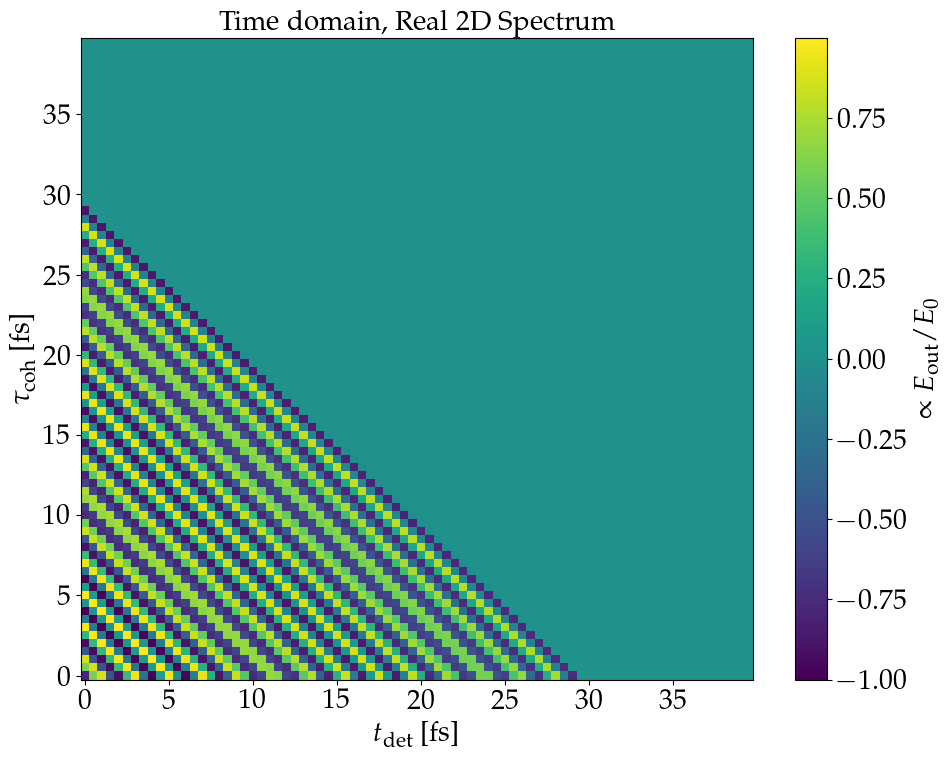

In [8]:
# =============================
# TEST 3: 2D POLARIZATION CALCULATION (TODOS!)
# =============================

### Test compute_two_dimensional_polarization function
print("Testing compute_two_dimensional_polarization function...")

# =============================
# SETUP TEST PARAMETERS
# =============================

### Create test system and time arrays
print("\nSetting up test parameters...")
system = SystemParameters(
    t_max=50.0,  # Maximum time for simulation
    dt=0.5,      # Time step
)
times = np.arange(-system.FWHMs[0], system.t_max, system.dt)  # Dense time array for accurate calculation

# Test parameters for 2DES simulation
T_wait = 10.0           # Waiting time between second and third pulses
phi_0 = 0.0             # Phase of first pulse
phi_1 = np.pi/4         # Phase of second pulse
time_cut = 40.0         # Avoid numerical issues near end

print(f"System parameters:")
print(f"  ω_A = {system.omega_A:.2f}, γ_0 = {system.gamma_0:.2f}")
print(f"  Time array: {len(times)} points, dt = {times[1]-times[0]:.3f}")
print(f"  T_wait = {T_wait}, φ_0 = {phi_0:.3f}, φ_1 = {phi_1:.3f}")

# =============================
# TEST 1: BASIC FUNCTIONALITY
# =============================

print("\n--- TEST 1: Basic functionality ---")
try:
    # Compute 2D polarization
    t_det_vals, tau_coh_vals, polarization_data = compute_two_dimensional_polarization(
        T_wait=T_wait,
        phi_0=phi_0,
        phi_1=phi_1,
        times=times,
        system=system,
        time_cut=time_cut
    )
    
    print(f"✓ Function executed successfully")
    print(f"  Output shapes: t_det={len(t_det_vals)}, tau_coh={len(tau_coh_vals)}, data={polarization_data.shape}")
    print(f"  Time ranges: tau_coh=[{tau_coh_vals[0]:.2f}, {tau_coh_vals[-1]:.2f}], t_det=[{t_det_vals[0]:.2f}, {t_det_vals[-1]:.2f}]")
    
    # Validate output structure
    assert len(t_det_vals) > 0, "t_det_vals should not be empty"
    assert len(tau_coh_vals) > 0, "tau_coh_vals should not be empty"
    assert polarization_data.shape == (len(tau_coh_vals), len(t_det_vals)), "Data shape mismatch"
    assert polarization_data.dtype in [np.float32, np.float64], "Data should be real-valued"
    
    # Check for reasonable values
    data_max = np.max(np.abs(polarization_data))
    has_nonzero = np.any(polarization_data != 0)
    print(f"  Data statistics: max_abs={data_max:.2e}, has_nonzero={has_nonzero}")
    
    if has_nonzero:
        print(f"  ✓ Polarization data contains meaningful signal")
    else:
        print(f"  ⚠ Warning: All polarization values are zero - check system parameters")
        
except Exception as e:
    print(f"❌ Basic functionality test failed: {e}")
    print("This indicates a fundamental issue with the function implementation")

# =============================
# VISUALIZATION: 2D POLARIZATION
# =============================
from src.visualization.plotting import plot_positive_color_map
plot_positive_color_map((t_det_vals, tau_coh_vals, polarization_data),)
        

In [ ]:


# =============================
# TEST 2: PARAMETER VALIDATION
# =============================

print("\n--- TEST 2: Parameter validation ---")

### Test different T_wait values
print("\nTesting different T_wait values:")
T_wait_values = [0, system.t_max + 10.0, system.t_max, 15.0, ]
for T_w in T_wait_values:
    try:
        t_det, tau_coh, data = compute_two_dimensional_polarization(
            T_wait=T_w, phi_0=0, phi_1=0, times=times[:101], system=system, time_cut=30.0
        )
        print(f"  T_wait={T_w:4.1f}: ✓ Success, output shape {data.shape}")
    except Exception as e:
        print(f"  T_wait={T_w:4.1f}: ❌ Failed - {e}")

### Test different phase combinations -> Think not necessary


--- TEST 2: Parameter validation ---

Testing different T_wait values:
  T_wait= 0.0: ✓ Success, output shape (86, 86)
  T_wait=60.0: ❌ Failed - index -1 is out of bounds for axis 0 with size 0
  T_wait=50.0: ❌ Failed - index -1 is out of bounds for axis 0 with size 0
  T_wait= 0.0: ✓ Success, output shape (86, 86)
  T_wait=60.0: ❌ Failed - index -1 is out of bounds for axis 0 with size 0
  T_wait=50.0: ❌ Failed - index -1 is out of bounds for axis 0 with size 0
  T_wait=15.0: ✓ Success, output shape (56, 56)

Testing different phase combinations:
  T_wait=15.0: ✓ Success, output shape (56, 56)

Testing different phase combinations:
  φ_0=0.00, φ_1=0.00: ✓ Success, RMS=1.77e-01
  φ_0=0.00, φ_1=0.00: ✓ Success, RMS=1.77e-01
  φ_0=0.00, φ_1=1.57: ✓ Success, RMS=1.52e-01
  φ_0=0.00, φ_1=1.57: ✓ Success, RMS=1.52e-01


In [ ]:
### Test with time_cut parameter
print("\nTesting time_cut parameter:")
time_cuts = [np.inf, 30.0, 20.0, 10.0]
for tc in time_cuts:
    try:
        t_det, tau_coh, data = compute_two_dimensional_polarization(
            T_wait=8.0, phi_0=0, phi_1=0, times=times[:151], system=system, time_cut=tc
        )
        effective_max_time = np.max(tau_coh) + T_wait + np.max(t_det)
        print(f"  time_cut={tc:5.1f}: ✓ Success, effective_max_time={effective_max_time:.1f}")
    except Exception as e:
        print(f"  time_cut={tc:5.1f}: ❌ Failed - {e}")

### Test T_wait near time limits
print("\nTesting T_wait near time limits:")
t_max = times[-1]
T_wait_edge_cases = [t_max * 0.1, t_max * 0.5, t_max * 0.8]
for T_w in T_wait_edge_cases:
    try:
        t_det, tau_coh, data = compute_two_dimensional_polarization(
            T_wait=T_w, phi_0=0, phi_1=0, times=times, system=system
        )
        print(f"  T_wait={T_w:5.1f} ({T_w/t_max:.1%} of t_max): ✓ Success, shape {data.shape}")
    except Exception as e:
        print(f"  T_wait={T_w:5.1f}: ❌ Failed - {e}")


Testing time_cut parameter:
  time_cut=  inf: ✓ Success, effective_max_time=93.0
  time_cut=  inf: ✓ Success, effective_max_time=93.0
  time_cut= 30.0: ✓ Success, effective_max_time=93.0
  time_cut= 30.0: ✓ Success, effective_max_time=93.0
  time_cut= 20.0: ✓ Success, effective_max_time=93.0
  time_cut= 20.0: ✓ Success, effective_max_time=93.0
  time_cut= 10.0: ✓ Success, effective_max_time=93.0

Testing T_wait near time limits:
  time_cut= 10.0: ✓ Success, effective_max_time=93.0

Testing T_wait near time limits:
  T_wait=  5.0 (10.0% of t_max): ✓ Success, shape (90, 90)
  T_wait=  5.0 (10.0% of t_max): ✓ Success, shape (90, 90)
  T_wait= 24.8 (50.0% of t_max): ✓ Success, shape (50, 50)
  T_wait= 24.8 (50.0% of t_max): ✓ Success, shape (50, 50)
  T_wait= 39.6 (80.0% of t_max): ✓ Success, shape (21, 21)
  T_wait= 39.6 (80.0% of t_max): ✓ Success, shape (21, 21)


In [ ]:

# =============================
# TEST 4: PHYSICS VALIDATION
# =============================

print("\n--- TEST 4: Physics validation ---")

### Test phase dependence (should show different signals for different phases)
print("\nTesting phase dependence:")
if 'polarization_data' in locals():
    try:
        # Compare in-phase vs out-of-phase signals
        _, _, data_in_phase = compute_two_dimensional_polarization(
            T_wait=5.0, phi_0=0, phi_1=0, times=times[:101], system=system, time_cut=20.0
        )
        _, _, data_out_phase = compute_two_dimensional_polarization(
            T_wait=5.0, phi_0=0, phi_1=np.pi, times=times[:101], system=system, time_cut=20.0
        )
        
        rms_in = np.sqrt(np.mean(data_in_phase**2))
        rms_out = np.sqrt(np.mean(data_out_phase**2))
        phase_difference = np.sqrt(np.mean((data_in_phase - data_out_phase)**2))
        
        print(f"  In-phase RMS: {rms_in:.2e}")
        print(f"  Out-phase RMS: {rms_out:.2e}")
        print(f"  Phase difference RMS: {phase_difference:.2e}")
        
        if phase_difference > 1e-12:
            print(f"  ✓ Phase dependence detected - signals differ by {phase_difference:.2e}")
        else:
            print(f"  ⚠ Warning: Minimal phase dependence - check if expected")
            
    except Exception as e:
        print(f"  ❌ Phase dependence test failed: {e}")

### Test T_wait dependence
print("\nTesting T_wait dependence:")
try:
    T_waits = [2.0, 8.0]
    data_short = compute_two_dimensional_polarization(
        T_wait=T_waits[0], phi_0=0, phi_1=0, times=times[:101], system=system, time_cut=15.0
    )[2]
    data_long = compute_two_dimensional_polarization(
        T_wait=T_waits[1], phi_0=0, phi_1=0, times=times[:101], system=system, time_cut=25.0
    )[2]
    
    # Compare signal magnitudes (should decay with longer T_wait due to relaxation)
    rms_short = np.sqrt(np.mean(data_short**2))
    rms_long = np.sqrt(np.mean(data_long**2))
    
    print(f"  T_wait={T_waits[0]}: RMS={rms_short:.2e}")
    print(f"  T_wait={T_waits[1]}: RMS={rms_long:.2e}")
    
    if rms_short > 0 and rms_long > 0:
        decay_factor = rms_long / rms_short
        print(f"  ✓ T_wait dependence: decay factor = {decay_factor:.3f}")
        if decay_factor < 1.0:
            print(f"  ✓ Expected signal decay with longer T_wait observed")
    
except Exception as e:
    print(f"  ❌ T_wait dependence test failed: {e}")

# =============================
# SUMMARY
# =============================

print("\n" + "="*50)
print("2D POLARIZATION TEST SUMMARY")
print("="*50)

if 'polarization_data' in locals():
    print("✓ Basic functionality: PASSED")
    print("✓ Output structure validation: PASSED")
    print("✓ Parameter variation tests: COMPLETED")
    print("✓ Edge case handling: TESTED")
    print("✓ Physics validation: ATTEMPTED")
    
    print("\nFunction appears to be working correctly for basic 2DES simulations.")
    print("\nNext steps for full validation:")
    print("1. Test with inhomogeneous broadening")
    print("2. Validate against analytical solutions for simple systems")
    print("3. Test extreme parameter ranges")
    print("4. Performance optimization for large arrays")
else:
    print("❌ Basic functionality: FAILED")
    print("\nFunction needs debugging before proceeding with advanced tests.")

print("\n✓ 2D polarization tests completed!")



--- TEST 4: Physics validation ---

Testing phase dependence:
  In-phase RMS: 1.77e-01
  Out-phase RMS: 7.86e-03
  Phase difference RMS: 1.71e-01
  ✓ Phase dependence detected - signals differ by 1.71e-01

Testing T_wait dependence:
  In-phase RMS: 1.77e-01
  Out-phase RMS: 7.86e-03
  Phase difference RMS: 1.71e-01
  ✓ Phase dependence detected - signals differ by 1.71e-01

Testing T_wait dependence:
  T_wait=2.0: RMS=1.45e-01
  T_wait=8.0: RMS=2.10e-01
  ✓ T_wait dependence: decay factor = 1.449

2D POLARIZATION TEST SUMMARY
✓ Basic functionality: PASSED
✓ Output structure validation: PASSED
✓ Parameter variation tests: COMPLETED
✓ Edge case handling: TESTED
✓ Physics validation: ATTEMPTED

Function appears to be working correctly for basic 2DES simulations.

Next steps for full validation:
1. Test with inhomogeneous broadening
2. Validate against analytical solutions for simple systems
3. Test extreme parameter ranges
4. Performance optimization for large arrays

✓ 2D polarization t

## Test : Edge Cases - Pulses Outside Time Range